In [53]:
%%time
import pandas as pd
import dask.dataframe as dd
import praw
from dask.diagnostics import ProgressBar
from tqdm import tqdm
import hashlib
from PIL import Image
import requests
from io import BytesIO
from shared_code.utility.schemas.pyarrow_schema import schema
from shared_code.utility.spark.set_environ import set_azure_env
import os
import torch
from pandas.core.groupby import DataFrameGroupBy
import os

from tqdm.dask import TqdmCallback

cb = TqdmCallback(desc="global")
cb.register()

set_azure_env()

from shared_code.utility.storage.azure_file_storage import AzureFileStorageAdapter
from shared_code.utility.scripts.blip_caption import BlipCaption

file_system = AzureFileStorageAdapter('data').get_file_storage()

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
def filter_on_existing_thumbnail_path(x: object) -> bool:
	try:
		path = x['thumbnail_path']
		return os.path.exists(path)
	except:
		return False

In [ ]:
def get_image_bytes(x: object) -> object:
	try:
		path = x['path']
		data = open(path, 'rb').read()
		return data
	except:
		return None

In [61]:
%%time
with tqdm() as pbar:
	extant_data = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system,
								  schema=schema)
	display(extant_data)

  0%|          | 0/100 [00:00<?, ?it/s]

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000d16,SFWNextDoorGirls,princessxo699,Thoughts about my NYE party outfit?,a woman sitting on a table holding a pink flower,9951b4f82caeb8ba2bd9f79f8d422450,/r/SFWNextDoorGirls/comments/1000d16/thoughts_...,https://i.imgur.com/GgFEagO.jpg,GgFEagO.jpg,D:\data\images\SFWNextDoorGirls\GgFEagO.jpg,D:\data\images\SFWNextDoorGirls\thumbnail\GgFE...,True,False
2,1000fg0,HotGirlNextDoor,BlkBrd1312,(IKTR),a woman in a bikini with a cell phone in her hand,be8dd55e34216bec1e15e03fa296eacc,/r/HotGirlNextDoor/comments/1000fg0/iktr/,https://i.redd.it/nwa7hts2jb9a1.jpg,nwa7hts2jb9a1.jpg,D:\data\images\HotGirlNextDoor\nwa7hts2jb9a1.jpg,D:\data\images\HotGirlNextDoor\thumbnail\nwa7h...,True,False
3,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
4,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19456,z1nql5,amihot,Sztofu160,20F give me a rating 1-10. No sugar coating!,blond woman with glasses and a pink shirt is p...,d1efc2c2db058fcaa0cfadc9a1e965ef,/r/amihot/comments/z1nql5/20f_give_me_a_rating...,https://i.redd.it/4pcnjmtt0i1a1.jpg,d1efc2c2db058fcaa0cfadc9a1e965ef.jpg,D:\data\images\amihot\d1efc2c2db058fcaa0cfadc9...,D:\data\images\amihot\thumbnail\d1efc2c2db058f...,True,False
19457,z1np44,amihot,lustymarriaaa,F31 Good morning y'all new on here what's my m...,blond blond woman in pink pajamas and black ja...,568cc01089098d3ae386d4d51bcf1fbe,/r/amihot/comments/z1np44/f31_good_morning_yal...,https://i.redd.it/xjb78w5uig1a1.jpg,568cc01089098d3ae386d4d51bcf1fbe.jpg,D:\data\images\amihot\568cc01089098d3ae386d4d5...,D:\data\images\amihot\thumbnail\568cc01089098d...,True,False
19458,z1nj3g,amihot,None,"F18 hot idk, hormy yes",woman sitting in a chair with her legs crossed...,d6ca90c80540ddc24791f4c185221ce4,/r/amihot/comments/z1nj3g/f18_hot_idk_hormy_yes/,https://i.redd.it/a7gk1s9eyh1a1.jpg,d6ca90c80540ddc24791f4c185221ce4.jpg,D:\data\images\amihot\d6ca90c80540ddc24791f4c1...,D:\data\images\amihot\thumbnail\d6ca90c80540dd...,True,False
19459,z1nika,amihot,sq_babe01,F21 who's down for FaceTime lemme help you nut...,a woman with a big breasty is showing off her ...,c0d84ad85ecf0aa67b3a0f2efc3f315b,/r/amihot/comments/z1nika/f21_whos_down_for_fa...,https://i.redd.it/llt0tpy7yh1a1.jpg,c0d84ad85ecf0aa67b3a0f2efc3f315b.jpg,D:\data\images\amihot\c0d84ad85ecf0aa67b3a0f2e...,D:\data\images\amihot\thumbnail\c0d84ad85ecf0a...,True,False


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: total: 172 ms
Wall time: 614 ms


CPU times: total: 1.72 s
Wall time: 5.04 s


<Axes: xlabel='subreddit'>

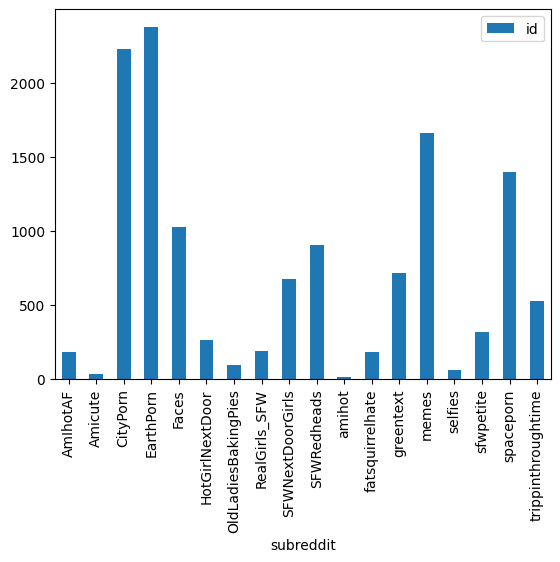

In [68]:
%%time
temp = extant_data.copy()

temp['exists'] = extant_data.apply(lambda x: filter_on_existing_thumbnail_path(x), axis=1)

grouped: DataFrameGroupBy = temp \
	.where(lambda x: x['exists']) \
	.groupby('subreddit')

grouped.count().plot.bar(y='id')

In [69]:
%%time

memes_frame = extant_data \
	.where(lambda x: x['exists']) \
	.where(lambda x: x['subreddit'].str.contains('memes')) \
	.dropna() \
	.reset_index(drop=True)

display(memes_frame)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1011n5h,memes,Traditional-Log7358,Shit just got real,a picture taken from a moving truck of a deliv...,25da99e545b1698f7a9919d782f78a32,/r/memes/comments/1011n5h/shit_just_got_real/,https://i.redd.it/oni9aqkl8l9a1.jpg,oni9aqkl8l9a1.jpg,/data/images/memes/oni9aqkl8l9a1.jpg,/data/images/memes/thumbnail/oni9aqkl8l9a1.jpg,True,False
1,1011nly,memes,Blue-Opal-Art,That’s gross,a woman in a white shirt and black jacket with...,d3c1783681e7225f28f3f63788407a8a,/r/memes/comments/1011nly/thats_gross/,https://i.redd.it/8l4tzzup8l9a1.jpg,8l4tzzup8l9a1.jpg,/data/images/memes/8l4tzzup8l9a1.jpg,/data/images/memes/thumbnail/8l4tzzup8l9a1.jpg,True,False
2,1011ny8,memes,Chungusmarrage,I hate ni,a man in a black shirt is taking a selfie in f...,519eda5e9146d3eb85b055d35f4c6789,/r/memes/comments/1011ny8/i_hate_ni/,https://i.redd.it/4xu3fh0t8l9a1.jpg,4xu3fh0t8l9a1.jpg,/data/images/memes/4xu3fh0t8l9a1.jpg,/data/images/memes/thumbnail/4xu3fh0t8l9a1.jpg,True,False
3,1011q0t,memes,Eli_the_Gamer,"Tis the holidays, what a fun time.",they're just like they're - - they're - build ...,3e6d71eeae194c7c6f714c31210808c4,/r/memes/comments/1011q0t/tis_the_holidays_wha...,https://i.redd.it/igde8zva9l9a1.jpg,igde8zva9l9a1.jpg,/data/images/memes/igde8zva9l9a1.jpg,/data/images/memes/thumbnail/igde8zva9l9a1.jpg,True,False
4,1011rsu,memes,pizzashizz6991,a message from the Martians to humans,a picture of a group of people in costumes wit...,34a2a283e5ed28f4a95fe0591f0ae098,/r/memes/comments/1011rsu/a_message_from_the_m...,https://i.redd.it/87hv9xwq9l9a1.jpg,87hv9xwq9l9a1.jpg,/data/images/memes/87hv9xwq9l9a1.jpg,/data/images/memes/thumbnail/87hv9xwq9l9a1.jpg,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,10sb9yo,memes,Enough_Lawyer_6089,Big brain thinking right here folks,a man in a suit and tie is standing in front o...,6e99d4ead4659c6cc235a3bd6af68d8a,/r/memes/comments/10sb9yo/big_brain_thinking_r...,https://i.redd.it/5kjy22gy1yfa1.jpg,6e99d4ead4659c6cc235a3bd6af68d8a.jpg,D:\data\images\memes\6e99d4ead4659c6cc235a3bd6...,D:\data\images\memes\thumbnail\6e99d4ead4659c6...,True,False
1654,10sb98w,memes,JSPIN53p,Interesting title,a close up of a cat with a cat face and a smil...,2caac318ef648691db44cbd65d213732,/r/memes/comments/10sb98w/interesting_title/,https://i.redd.it/4qhhnvqr1yfa1.jpg,2caac318ef648691db44cbd65d213732.jpg,D:\data\images\memes\2caac318ef648691db44cbd65...,D:\data\images\memes\thumbnail\2caac318ef64869...,True,False
1655,10sb6ql,memes,felix_emo,Idk,a picture of a loaf of bread with the words br...,cecc6cf76b5bbb8338fd17ff385216af,/r/memes/comments/10sb6ql/idk/,https://i.redd.it/fyjm80ejjwfa1.jpg,cecc6cf76b5bbb8338fd17ff385216af.jpg,D:\data\images\memes\cecc6cf76b5bbb8338fd17ff3...,D:\data\images\memes\thumbnail\cecc6cf76b5bbb8...,True,False
1656,10sb5tt,memes,Eli_the_Gamer,Rich kid.,a cartoon picture of a cartoon drawing of a ma...,ac7b65c2ab570cf2c089d9ce77d353ff,/r/memes/comments/10sb5tt/rich_kid/,https://i.redd.it/uu9d6c0w0yfa1.jpg,ac7b65c2ab570cf2c089d9ce77d353ff.jpg,D:\data\images\memes\ac7b65c2ab570cf2c089d9ce7...,D:\data\images\memes\thumbnail\ac7b65c2ab570cf...,True,False


CPU times: total: 93.8 ms
Wall time: 93.8 ms


In [70]:
df = pd.DataFrame(data=[memes_frame['path'], memes_frame['image_name'], memes_frame['caption'], memes_frame['title']],
				  index=['path', 'image_name', 'caption', 'title']).T

display(df)

,path,image_name,caption,title
0,/data/images/memes/oni9aqkl8l9a1.jpg,oni9aqkl8l9a1.jpg,a picture taken from a moving truck of a deliv...,Shit just got real
1,/data/images/memes/8l4tzzup8l9a1.jpg,8l4tzzup8l9a1.jpg,a woman in a white shirt and black jacket with...,That’s gross
2,/data/images/memes/4xu3fh0t8l9a1.jpg,4xu3fh0t8l9a1.jpg,a man in a black shirt is taking a selfie in f...,I hate ni
3,/data/images/memes/igde8zva9l9a1.jpg,igde8zva9l9a1.jpg,they're just like they're - - they're - build ...,"Tis the holidays, what a fun time."
4,/data/images/memes/87hv9xwq9l9a1.jpg,87hv9xwq9l9a1.jpg,a picture of a group of people in costumes wit...,a message from the Martians to humans
...,...,...,...,...
1653,D:\data\images\memes\6e99d4ead4659c6cc235a3bd6...,6e99d4ead4659c6cc235a3bd6af68d8a.jpg,a man in a suit and tie is standing in front o...,Big brain thinking right here folks
1654,D:\data\images\memes\2caac318ef648691db44cbd65...,2caac318ef648691db44cbd65d213732.jpg,a close up of a cat with a cat face and a smil...,Interesting title
1655,D:\data\images\memes\cecc6cf76b5bbb8338fd17ff3...,cecc6cf76b5bbb8338fd17ff385216af.jpg,a picture of a loaf of bread with the words br...,Idk
1656,D:\data\images\memes\ac7b65c2ab570cf2c089d9ce7...,ac7b65c2ab570cf2c089d9ce77d353ff.jpg,a cartoon picture of a cartoon drawing of a ma...,Rich kid.


In [71]:
%%time

with tqdm(total=len(df)) as progress:
	df['image_data'] = df.progress_apply(lambda x: get_image_bytes(x), axis=1)

display(df)

  0%|          | 0/1658 [00:03<?, ?it/s]


,path,image_name,caption,title,image_data
0,/data/images/memes/oni9aqkl8l9a1.jpg,oni9aqkl8l9a1.jpg,a picture taken from a moving truck of a deliv...,Shit just got real,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,/data/images/memes/8l4tzzup8l9a1.jpg,8l4tzzup8l9a1.jpg,a woman in a white shirt and black jacket with...,That’s gross,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,/data/images/memes/4xu3fh0t8l9a1.jpg,4xu3fh0t8l9a1.jpg,a man in a black shirt is taking a selfie in f...,I hate ni,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,/data/images/memes/igde8zva9l9a1.jpg,igde8zva9l9a1.jpg,they're just like they're - - they're - build ...,"Tis the holidays, what a fun time.",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,/data/images/memes/87hv9xwq9l9a1.jpg,87hv9xwq9l9a1.jpg,a picture of a group of people in costumes wit...,a message from the Martians to humans,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...,...,...
1653,D:\data\images\memes\6e99d4ead4659c6cc235a3bd6...,6e99d4ead4659c6cc235a3bd6af68d8a.jpg,a man in a suit and tie is standing in front o...,Big brain thinking right here folks,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1654,D:\data\images\memes\2caac318ef648691db44cbd65...,2caac318ef648691db44cbd65d213732.jpg,a close up of a cat with a cat face and a smil...,Interesting title,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1655,D:\data\images\memes\cecc6cf76b5bbb8338fd17ff3...,cecc6cf76b5bbb8338fd17ff385216af.jpg,a picture of a loaf of bread with the words br...,Idk,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1656,D:\data\images\memes\ac7b65c2ab570cf2c089d9ce7...,ac7b65c2ab570cf2c089d9ce77d353ff.jpg,a cartoon picture of a cartoon drawing of a ma...,Rich kid.,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


CPU times: total: 1.48 s
Wall time: 4 s


In [84]:
new_df = pd.DataFrame.from_records(df.to_records(index=False))

,path,image_name,caption,title,image_data
0,/data/images/memes/oni9aqkl8l9a1.jpg,oni9aqkl8l9a1.jpg,a picture taken from a moving truck of a deliv...,Shit just got real,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,/data/images/memes/8l4tzzup8l9a1.jpg,8l4tzzup8l9a1.jpg,a woman in a white shirt and black jacket with...,That’s gross,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,/data/images/memes/4xu3fh0t8l9a1.jpg,4xu3fh0t8l9a1.jpg,a man in a black shirt is taking a selfie in f...,I hate ni,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,/data/images/memes/igde8zva9l9a1.jpg,igde8zva9l9a1.jpg,they're just like they're - - they're - build ...,"Tis the holidays, what a fun time.",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,/data/images/memes/87hv9xwq9l9a1.jpg,87hv9xwq9l9a1.jpg,a picture of a group of people in costumes wit...,a message from the Martians to humans,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...,...,...
1653,D:\data\images\memes\6e99d4ead4659c6cc235a3bd6...,6e99d4ead4659c6cc235a3bd6af68d8a.jpg,a man in a suit and tie is standing in front o...,Big brain thinking right here folks,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1654,D:\data\images\memes\2caac318ef648691db44cbd65...,2caac318ef648691db44cbd65d213732.jpg,a close up of a cat with a cat face and a smil...,Interesting title,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1655,D:\data\images\memes\cecc6cf76b5bbb8338fd17ff3...,cecc6cf76b5bbb8338fd17ff385216af.jpg,a picture of a loaf of bread with the words br...,Idk,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1656,D:\data\images\memes\ac7b65c2ab570cf2c089d9ce7...,ac7b65c2ab570cf2c089d9ce77d353ff.jpg,a cartoon picture of a cartoon drawing of a ma...,Rich kid.,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
